### Overview
- This code demonstrates how Laplacian variance (from the *opencv* library) can be used to filter out cloudy images from the dataset. This is a common occurrence in the dataset that occurs during the extraction of gradient restored - images from L3.  
- The Laplacian of $f$ is $\nabla\cdot\nabla f=\nabla^2 f$; the divergence of the gradient. Thus, applying this function across an image and computing the variance of the output can in-theory identify discontinuities/edges caused by clouds. An image with a high Laplacian variance is considered 'bad'. 
- To demonstrate this, I labelled 400 images from the dataset as 'good' or 'bad' and computed their associated Laplacian variance. The Laplacian variance distribution at the bottom demonstrates a clear distinction between good and bad images. 
- From this, we define a filtering threshold that is used in the 'data_extract' code. 

In [7]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import xarray as xr
import copy
import random
import cv2

### Import 

In [ ]:
data_path = 'l3_blended_l4_extracts_gR_201703.nc'
ds = xr.open_dataset(data_path)
num_images = 500
rand_indices = np.random.randint(0, len(ds.gRsst), num_images)
ds = ds.isel(i=rand_indices)

### Labelling Code
Create an IPyWidget with 'good', 'bad' or 'not sure' buttons for images and store the indices of the associated images.

In [ ]:
# Assuming ds.gRsst is your dataset of images
good_images_indices = []
bad_images_indices = []
ns_images_indices = []

# Variable to keep track of the current image index
current_index = 0

# Create an Output widget to display images
image_output = widgets.Output()

# Function to update the display with the current image
def update_display():
    with image_output:
        # Clear previous output in the Output widget
        clear_output(wait=True)
        plt.figure(figsize=(5, 5))
        plt.imshow(ds.gRsst[current_index])  # Adjust cmap based on your image type
        plt.title(f'Image {current_index+1}')
        plt.show()

# Function to handle the "Good" button click
def good_button_clicked(b):
    global current_index
    good_images_indices.append(current_index)
    current_index += 1
    show_next_image()

# Function to handle the "Bad" button click
def bad_button_clicked(b):
    global current_index
    bad_images_indices.append(current_index)
    current_index += 1
    show_next_image()

def ns_button_clicked(b):
    global current_index
    ns_images_indices.append(current_index)
    current_index += 1
    show_next_image()

# Function to show the next image
def show_next_image():
    global current_index
    if current_index < len(ds.gRsst):
        update_display()
    else:
        with image_output:
            clear_output(wait=True)
            print("No more images.")

# Creating the "Good" and "Bad" buttons
good_button = widgets.Button(description="Good")
bad_button = widgets.Button(description="Bad")
ns_button = widgets.Button(description="Not Sure")

good_button.on_click(good_button_clicked)
bad_button.on_click(bad_button_clicked)
ns_button.on_click(ns_button_clicked)

# Group the buttons
buttons = widgets.HBox([good_button, bad_button, ns_button])

# Display the buttons and the Output widget
display(buttons, image_output)

# Initialize the display with the first image
update_display()

### Extract good & bad data

In [ ]:
good = np.zeros(len(ds.gRsst))
good[good_images_indices] = 1
ds['good'] = (('i',), good)
# drop unsure cases
ds_filtered = ds.drop_sel(i=ns_images_indices)

In [ ]:
ds = xr.Dataset({'gRsst': ds_filtered.gRsst,
                 'good': ds_filtered.good})
ds = ds.expand_dims(dim='channel', axis=1)
ds.to_netcdf('quality_training')

### Load and Separate Data

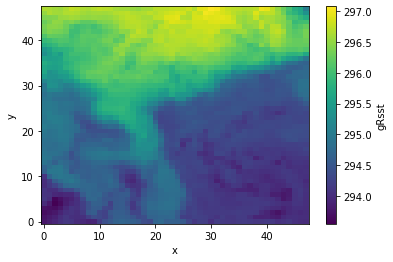

In [2]:
## run if you already have file
data_path = 'lustre_scratch/data/quality_training'
ds = xr.open_dataset(data_path)
ds.gRsst[22].plot()

### Compute Laplacian Variance
Find the Laplacian variance for good and bad images and plot the distribution.

In [4]:
def laplacian_variance(image):
    image_min = image.min()
    image_max = image.max()
    image_normalized = ((image - image_min) / (image_max - image_min) * 255).astype(np.uint8)
    laplacian = cv2.Laplacian(image, cv2.CV_64F) 
    variance = laplacian.var() 
    return variance

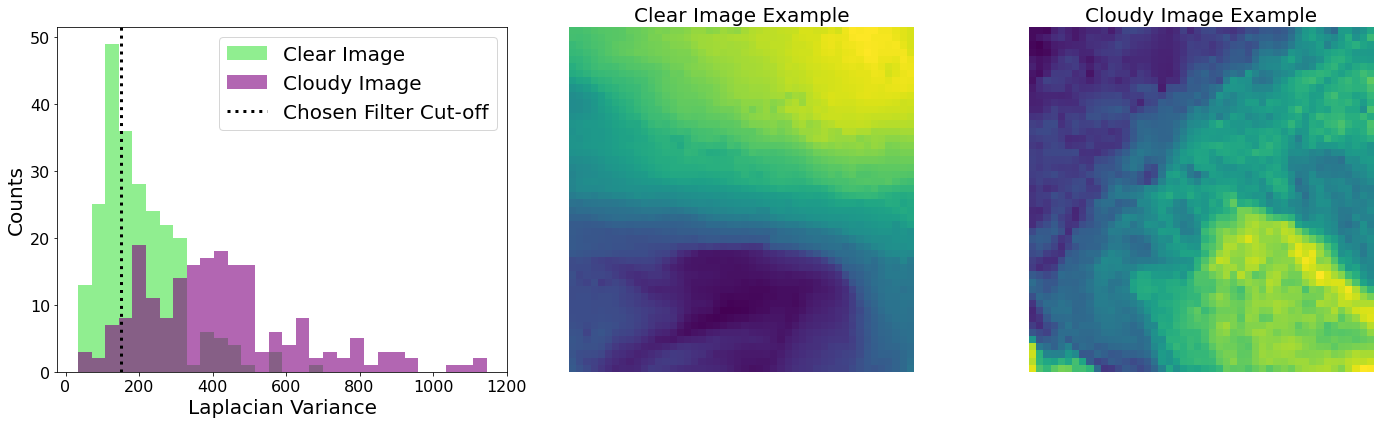

In [32]:
import numpy as np
import matplotlib.pyplot as plt

var_array_bad = []
var_array_good = []
very_bad_index = []
very_good_index = []
num_good = int(np.sum(ds.good.data))
num_bad = len(ds.good) - num_good

# Iterate over the images
for i, image in enumerate(ds.gRsst): 
    image = ds.gRsst[i].data[0]
    image_min = image.min()
    image_max = image.max()

    # Normalize the image
    image_normalized = ((image - image_min) / (image_max - image_min) * 255).astype(np.uint8)

    # Calculate Laplacian variance
    var = laplacian_variance(image_normalized)

    # Append the variance to the corresponding list
    if int(ds.good[i]) == 1: 
        var_array_good.append(var)
    elif int(ds.good[i]) == 0:
        var_array_bad.append(var)
    
    # Collect indices for specific variance range
    if 50 < var < 60: 
        very_good_index.append(i)
    elif 800 < var < 900: 
        very_bad_index.append(i)

# Combine all variances to determine common bins
all_vars = np.concatenate([var_array_good, var_array_bad])

# Define the bin edges using the combined data
bin_edges = np.linspace(all_vars.min(), all_vars.max(), 31)  # 30 bins

# Plot histograms with the same bins

# Create the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(20, 6))  # Adjust figsize for better proportion

# Plot the histograms on the first subplot
ax[0].hist(var_array_good, bins=bin_edges, color='lightgreen', label='Clear Image')
ax[0].hist(var_array_bad, bins=bin_edges, color='purple', alpha=0.6, label='Cloudy Image')
ax[0].set_xlabel('Laplacian Variance', fontsize=20)
ax[0].set_ylabel('Counts', fontsize=20)
ax[0].axvline(150, ls=':', color='black', linewidth=3, label='Chosen Filter Cut-off')
ax[0].legend(fontsize=20)

# Plot the clear image example on the second subplot
ax[1].imshow(ds.gRsst[very_good_index[0], 0])
ax[1].set_title('Clear Image Example', fontsize=20)
ax[1].axis('off')  # Hide axis ticks

# Plot the cloudy image example on the third subplot
ax[2].imshow(ds.gRsst[very_bad_index[1], 0])
ax[2].set_title('Cloudy Image Example', fontsize=20)
ax[2].axis('off')  # Hide axis ticks

ax[0].tick_params(axis='both', labelsize=16) 
# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
fig.savefig('plots/final_plots/cloudy.png', dpi=1400)

# Show the figure
plt.show()
